# Contact map processing from masking onwards

Previous to this, we have already produced an mcool file with duplicates removed, the reads positions shifted to nucleosome centers, and inward reads removed from i+1 and i+2 nucleosomes.

From here the steps are:
1. (a) Mask regions with low coverage based on min-nnz and mad-max filters (b) Mask entries for which neither end is covered by a capture probe
2. Standard ICE balancing
3. ICE balancing with interpolation of missing pixels
4. ICE balancing with frozen interpolated pixels
5. Neighbor balancing
6. Smoothing/coarsening

In [2]:
import cooler
from neighbor_balance.ice import get_capture_rates, filter_bins, ice_balance
from neighbor_balance.neighbor import normalize_contact_map_neighbor, normalize_contact_map_average, get_neighbor_factors
from neighbor_balance.smoothing import coarsen_contact_map, interpolate_nans, nan_gaussian_filter
from neighbor_balance.plotting import *

apply_matplotlib_style()
supercloud = '/home/joepaggi/share'

cool = f'{supercloud}/rcmc/WT_BR1/select_corrected_minus_inward.mcool'
capture_probes = f'{supercloud}/rcmc/captureprobes_mm39.bed'
capture_regions = f'{supercloud}/rcmc/captureregions_mm39.bed'

name = 'nanog'
region = 'chr6:122,480,000-122,850,000'
chrom, start, end = parse_region(region)

# Mask entries for which neither end is covered by a capture probe

In [3]:
def load_contact_map(cool, resolution, region, balance=True):
    c = cooler.Cooler(f'{cool}::/resolutions/{resolution}')
    return c.matrix(balance=balance).fetch(region)

mad_max = 2
min_nnz = 10
min_capture_rate = 0.5

capture_rates = get_capture_rates(capture_probes, chrom, start, end, bin_size=200)
contact_maps = {}
contact_maps['raw'] = load_contact_map(cool, 200, region, balance=False)

# Run standard ICE balancing.
masked = filter_bins(contact_maps['raw'].astype(float), capture_rates, mad_max=mad_max, min_nnz=min_nnz, min_pair_capture_rate=0.0)
contact_maps['default'], _ = ice_balance(masked, interpolate=False, max_iter=50, tol=1e-5, correct_for_flanks=False)
contact_maps['default'] = normalize_contact_map_average(contact_maps['default'], neighbor_prob=0.5, max_prob=0.95)

# Run ICE balancing with interpolation.
masked = filter_bins(contact_maps['raw'].astype(float), capture_rates, mad_max=mad_max, min_nnz=min_nnz, min_pair_capture_rate=min_capture_rate)
contact_maps['ICE (1)'], _ = ice_balance(masked, interpolate=False, max_iter=50, tol=1e-5, correct_for_flanks=True)
contact_maps['ICE (2)'], _ = ice_balance(contact_maps['ICE (1)'], interpolate=True, max_iter=50, tol=1e-5, correct_for_flanks=True)
contact_maps['ICE (3)'], _ = ice_balance(contact_maps['ICE (2)'], interpolate=False, correct_for_flanks=True)

# Final maps.
contact_maps['ice'] = normalize_contact_map_average(contact_maps['ICE (3)'], neighbor_prob=0.5, max_prob=0.95)
contact_maps['neighbor'] = normalize_contact_map_neighbor(contact_maps['ICE (3)'], bw=1, max_prob=0.95, neighbor_prob=0.5)
contact_maps['neighbor, smooth'] = coarsen_contact_map(contact_maps['neighbor'].copy())
contact_maps['ice, smooth'] = coarsen_contact_map(contact_maps['ice'].copy())
contact_maps['default, smooth'] = coarsen_contact_map(contact_maps['default'].copy())

# Repeat of the third ICE balancing step but not accounting for flanking regions.
contact_maps['ICE no flanks'], _ = ice_balance(contact_maps['ICE (2)'], interpolate=False, correct_for_flanks=False)

# Result of interploation without ICE balancing additional ICE balancing. Approximates result of simulations.
# Setting max_iter=0 means no ICE balancing is performed.
contact_maps['Interp no ICE'], _ = ice_balance(contact_maps['ICE (1)'], interpolate=True, max_iter=0, tol=1e-5, correct_for_flanks=True)

low_capture_pixels = capture_rates.reshape(-1, 1) + capture_rates.reshape(1, -1)
low_capture_pixels = low_capture_pixels < min_capture_rate

log_marginal = np.log10(get_marginal(contact_maps['raw']))
mad = np.median(np.abs(log_marginal - np.median(log_marginal)))
mad_max = log_marginal < np.median(log_marginal) - mad_max * np.median(mad)
mad_max_pixels = mad_max.reshape(-1, 1) | mad_max.reshape(1, -1)

mask = np.ones(low_capture_pixels.shape)
mask[low_capture_pixels] = 0
mask[mad_max_pixels] = 2

/orcd/home/002/joepaggi/neighbor-balance/neighbor_balance/ice.py:146: RuntimeWarning: divide by zero encountered in log
  log_marginal = np.log(get_marginal(contact_map))
/orcd/home/002/joepaggi/neighbor-balance/neighbor_balance/smoothing.py:162: RuntimeWarning: Mean of empty slice
  result[i:i+factor, j:j+factor] = agg(contact_map[i:i+factor, j:j+factor])
/tmp/ipykernel_2683664/806005408.py:41: RuntimeWarning: divide by zero encountered in log10
  log_marginal = np.log10(get_marginal(contact_maps['raw']))


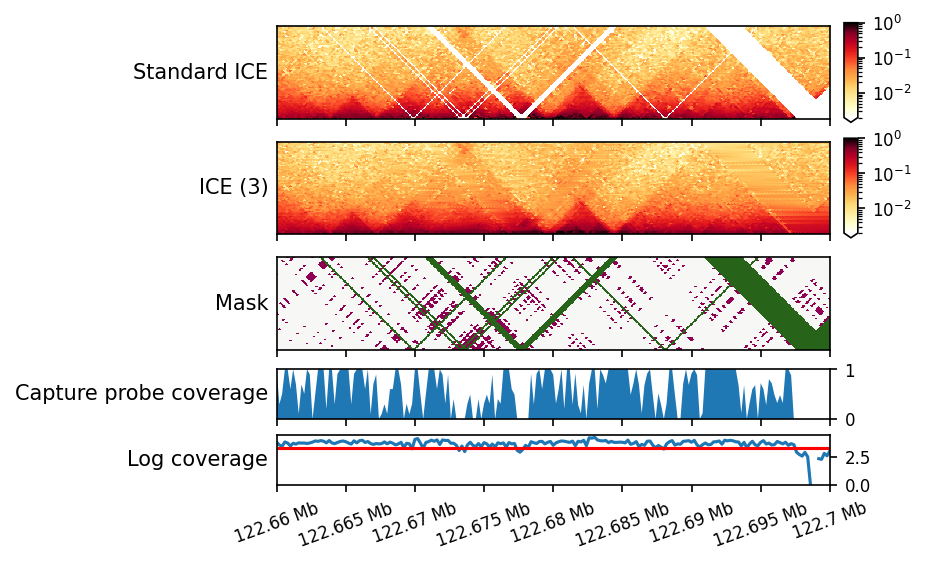

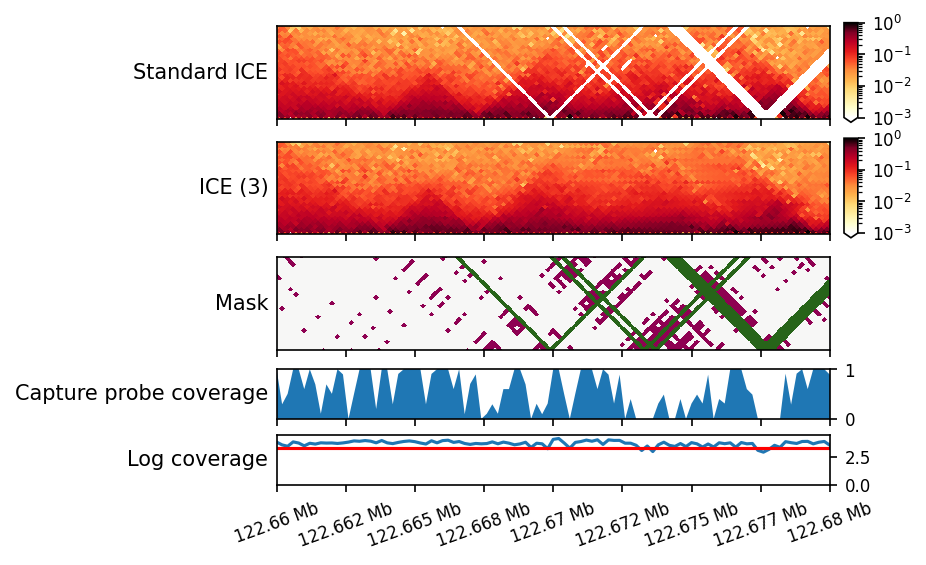

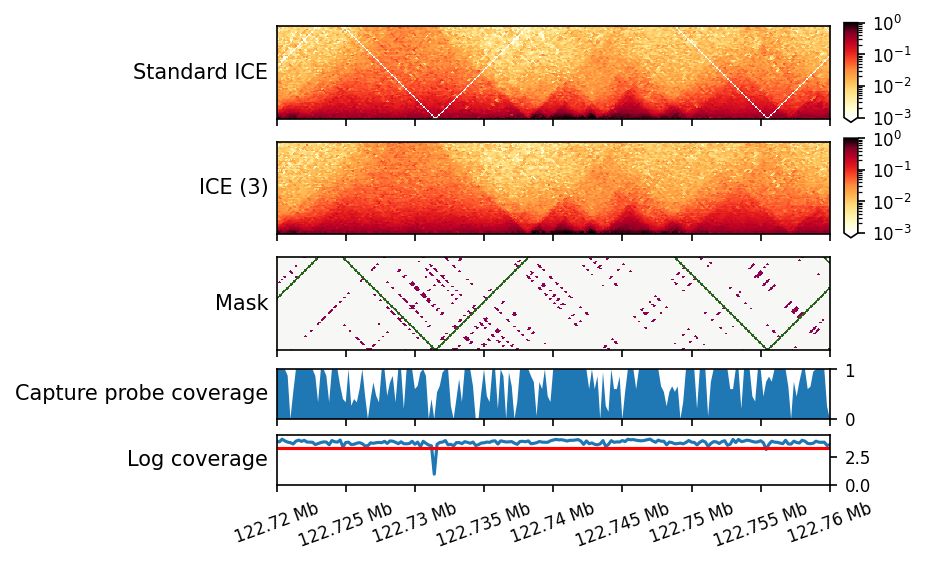

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pairwise_horizontal(contact_map, region, ax=None, colorbar=True, vmin=1e-3, vmax=1, cmap='fall', log_norm=True):
    chrom, start, end = parse_region(region)
    contact_map = ContactMap(contact_map, chrom=chrom, start=start, end=end, resolution=200)
    im = contact_map.plot_contact_map_horizontal(ax=ax, colorbar=colorbar, vmin=vmin, vmax=vmax, cmap=cmap, log_norm=log_norm)
    return im


def show_interpolation(zoom, fname=None, vmin=1e-3):
    fig, axs = plt.subplots(5, 2, figsize=(5, 4), sharex='col',
                            gridspec_kw={'hspace': 0.2, 'height_ratios': [2, 2, 2, 1, 1], 'wspace': 0.05, 'width_ratios': [40, 1]})

    ice_ax = axs[0, 0]
    ice_cbar_ax = axs[0, 1]
    mask_ax = axs[2, 0]
    axs[2, 1].axis('off')
    interp_ax = axs[1, 0]
    interp_cbar_ax = axs[1, 1]
    trace_ax = axs[3, 0]
    axs[3, 1].axis('off')
    mad_max_ax = axs[4, 0]
    axs[4, 1].axis('off')

    im = plot_pairwise_horizontal(contact_maps['default'], region, ax=ice_ax, colorbar=False, vmin=vmin, vmax=1)
    plt.colorbar(im, cax=ice_cbar_ax, extend='min')
    im = plot_pairwise_horizontal(contact_maps['ice'], region, ax=interp_ax, colorbar=False, vmin=vmin, vmax=1)
    plt.colorbar(im, cax=interp_cbar_ax, extend='min')
    im = plot_pairwise_horizontal(mask, region, ax=mask_ax, colorbar=False, cmap='PiYG', log_norm=False, vmin=0, vmax=2)
    #plt.colorbar(im, cax=mask_cbar_ax, extend='neither')

    for ax in [ice_ax, mask_ax, interp_ax]:
        ax.set_yticks([])
        ax.set_xlim(*zoom)
        ax.set_ylim(0, (zoom[1] - zoom[0]) / 3)

    trace_ax.fill_between(range(start, end, 200), 0, capture_rates)
    trace_ax.set_ylim(0, 1)
    trace_ax.yaxis.tick_right()

    mad_max_ax.plot(range(start, end, 200), log_marginal)
    mad_max_ax.axhline(np.median(log_marginal) - 2 * np.median(mad), color='red')
    mad_max_ax.yaxis.tick_right()
    mad_max_ax.set_ylim(0)
    format_ticks(mad_max_ax, y=False)

    ice_ax.set_ylabel('Standard ICE', rotation=0, ha='right', va='center')
    interp_ax.set_ylabel('ICE (3)', rotation=0, ha='right', va='center')
    mask_ax.set_ylabel('Mask', rotation=0, ha='right', va='center')
    trace_ax.set_ylabel('Capture probe coverage', rotation=0, ha='right', va='center')
    mad_max_ax.set_ylabel('Log coverage', rotation=0, ha='right', va='center')
    if fname is not None:
        plt.savefig(fname)
        plt.savefig(fname.replace('.pdf', '.png'), transparent=False)
    plt.show()

show_interpolation((122_660_000, 122_700_000), fname='img/interpolation_zoom.pdf', vmin=2e-3)
show_interpolation((122_660_000, 122_680_000))
show_interpolation((122_720_000, 122_760_000))

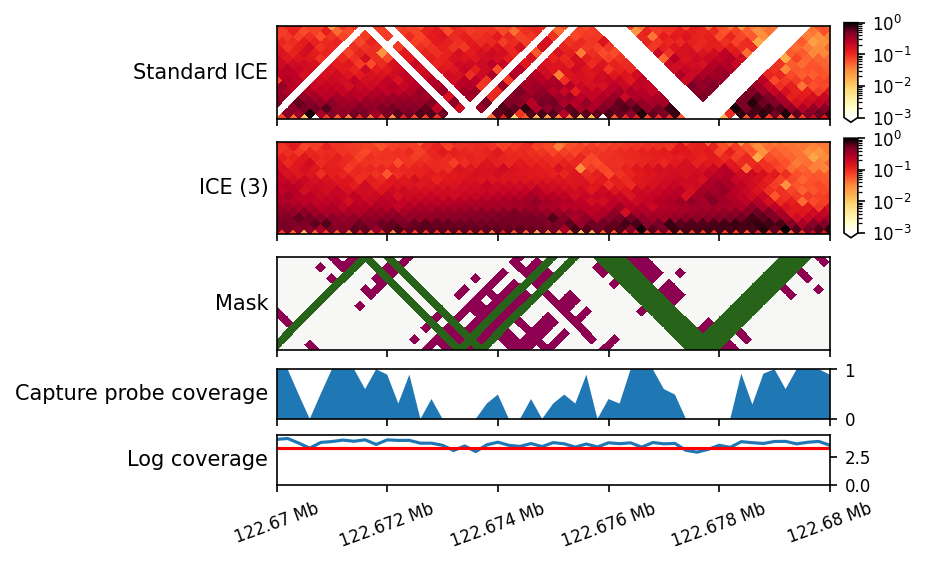

In [6]:
show_interpolation((122_670_000, 122_680_000))

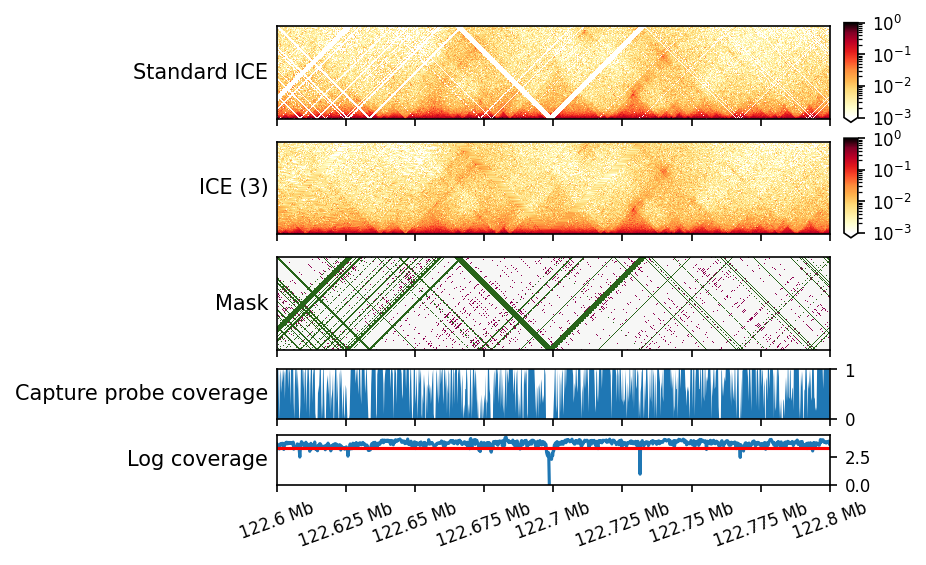

In [7]:
show_interpolation((122_600_000, 122_800_000))

# Without aggressive masking and interpolation the neighbor values have large dips that would be problematic for downstream analysis

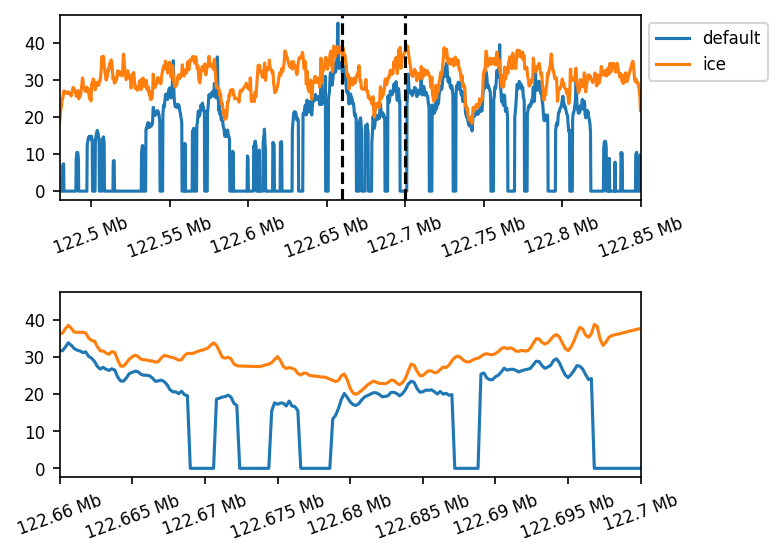

In [8]:
f, axs = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'hspace': 0.5})
for name in ['default', 'ice']:
    cmap = contact_maps[name]
    cmap = normalize_contact_map_neighbor(cmap, neighbor_prob=1.0, max_prob=10.0, bw=1, eps=1/5)
    #neighbors = get_neighbor_factors(np.diagonal(cmap, 1).copy(), average='arithmetic')
    #neighbors = nan_gaussian_filter(neighbors, 1, nan_policy='mask')
    marginal = get_marginal(cmap, k=0)
    for ax in axs:
        ax.plot(range(start, end, 200), marginal, label=name)
axs[1].set_xlim(122_660_000, 122_700_000)
axs[0].axvline(122_660_000, color='black', linestyle='--')
axs[0].axvline(122_700_000, color='black', linestyle='--')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[0].set_xlim(start, end)
format_ticks(axs[1], y=False)
format_ticks(axs[0], y=False)
plt.show()

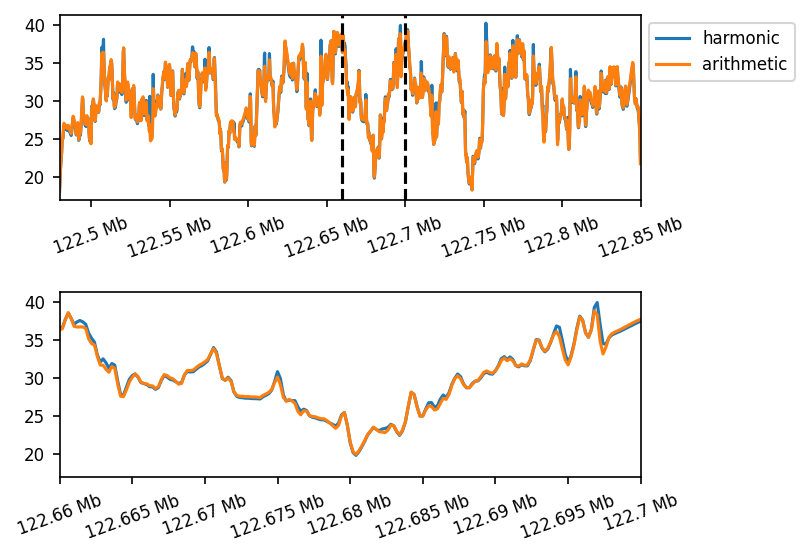

In [9]:
f, axs = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'hspace': 0.5})
for name in ['harmonic', 'arithmetic']:
    cmap = normalize_contact_map_neighbor(contact_maps['ice'], neighbor_prob=1.0, max_prob=10.0, bw=1, eps=1/5, average=name)
    #neighbors = get_neighbor_factors(np.diagonal(cmap, 1).copy(), average='arithmetic')
    #neighbors = nan_gaussian_filter(neighbors, 1, nan_policy='mask')
    marginal = get_marginal(cmap, k=0)
    for ax in axs:
        ax.plot(range(start, end, 200), marginal, label=name)
axs[1].set_xlim(122_660_000, 122_700_000)
axs[0].axvline(122_660_000, color='black', linestyle='--')
axs[0].axvline(122_700_000, color='black', linestyle='--')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[0].set_xlim(start, end)
format_ticks(axs[1], y=False)
format_ticks(axs[0], y=False)
plt.show()

# Not integrating interpolation into ICE balancing results in artificial variations in the expected contacts

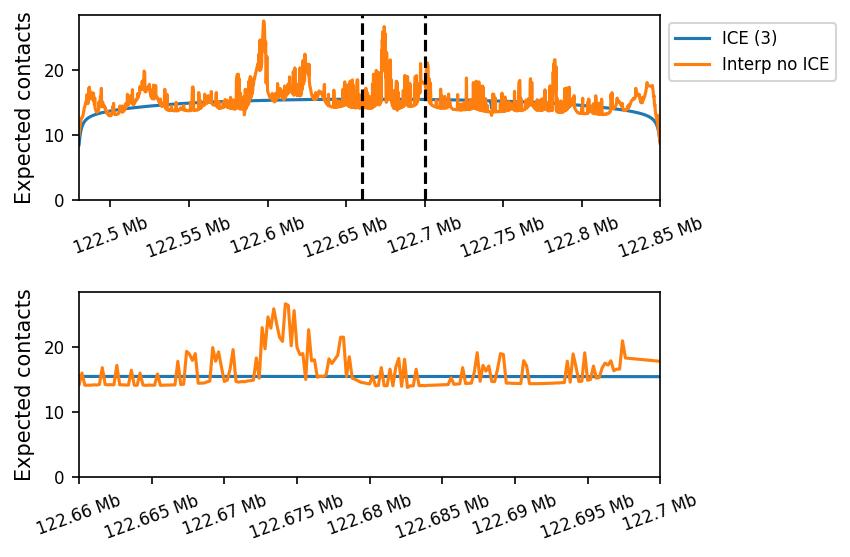

In [10]:
f, axs = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'hspace': 0.5})
for name in ['ICE (3)', 'Interp no ICE']:
    cmap = contact_maps[name]
    cmap = normalize_contact_map_average(cmap, neighbor_prob=0.5, max_prob=0.95)
    marginal = get_marginal(cmap)
    for ax in axs:
        ax.plot(range(start, end, 200), marginal, label=name)
axs[1].set_xlim(122_660_000, 122_700_000)
axs[0].axvline(122_660_000, color='black', linestyle='--')
axs[0].axvline(122_700_000, color='black', linestyle='--')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[0].set_xlim(start, end)
axs[0].set_ylabel('Expected contacts')
axs[1].set_ylabel('Expected contacts')
axs[1].set_ylim(0)
axs[0].set_ylim(0)
format_ticks(axs[1], y=False)
format_ticks(axs[0], y=False)
plt.savefig('img/interpolation_marginal.pdf')
plt.savefig('img/interpolation_marginal.png', transparent=False)
plt.show()

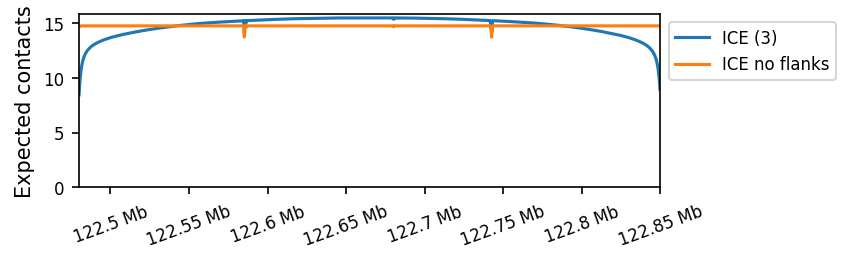

In [11]:
f, axs = plt.subplots(1, 1, figsize=(5, 1.5), gridspec_kw={'hspace': 0.5})
axs = [axs]
for name in ['ICE (3)', 'ICE no flanks']:
    cmap = contact_maps[name]
    cmap = normalize_contact_map_average(cmap, neighbor_prob=0.5, max_prob=0.95)
    marginal = get_marginal(cmap)
    for ax in axs:
        ax.plot(range(start, end, 200), marginal, label=name)
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[0].set_xlim(start, end)
axs[0].set_ylabel('Expected contacts')
axs[0].set_ylim(0)
format_ticks(axs[0], y=False)
plt.savefig('img/flank_marginal.pdf')
plt.savefig('img/flank_marginal.png', transparent=False)
plt.show()

# Visualizing the procedure for accounting for flanking regions

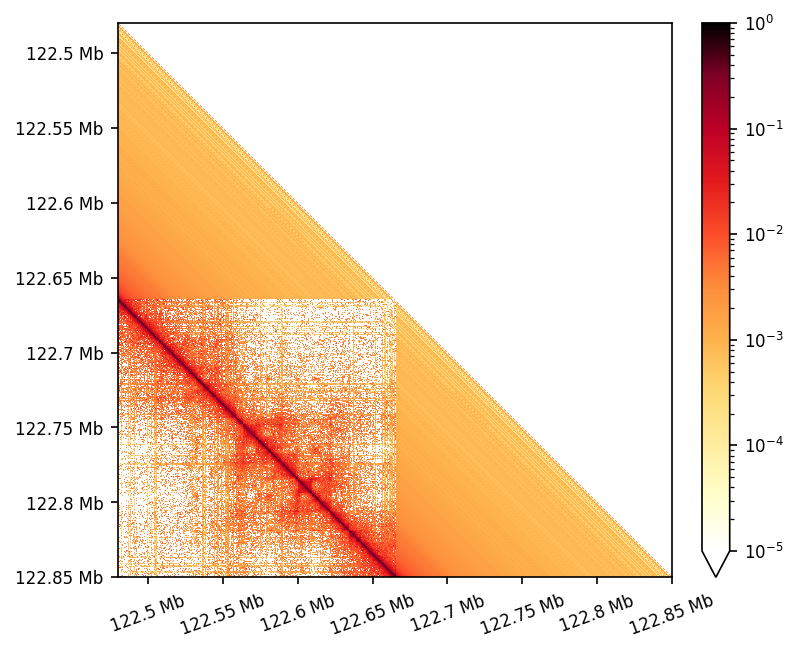

In [20]:
def plot_contact_map(contact_map, region, cmap='fall', ax=None, **kwargs):
    chrom, start, end = parse_region(region)
    contact_map = ContactMap(contact_map, chrom=chrom, start=start, end=end, resolution=200)
    return contact_map.plot_contact_map(cmap=cmap, ax=ax, **kwargs)

cmap = normalize_contact_map_average(contact_maps['ICE no flanks'], neighbor_prob=0.5, max_prob=0.95)
n = cmap.shape[0]
extended_contact_map = np.zeros((2*n - 1, 2*n - 1))
extended_contact_map[n-1:, :n] = cmap
ps = get_distance_average(cmap)
ps = interpolate_nans(ps)
for i in range(len(marginal)):
    extended_contact_map[n+i-1, n:n+i] = ps[n-i-1:]
    extended_contact_map[i:n-1, i] = ps[i:][::-1]

plot_contact_map(extended_contact_map, region)

# Performing neighbor balancing without first ICE balancing performs poorly...

In [18]:
contact_maps['neighbor, direct'] = normalize_contact_map_neighbor(contact_maps['raw'].astype(float), bw=1, max_prob=0.95, neighbor_prob=0.5)

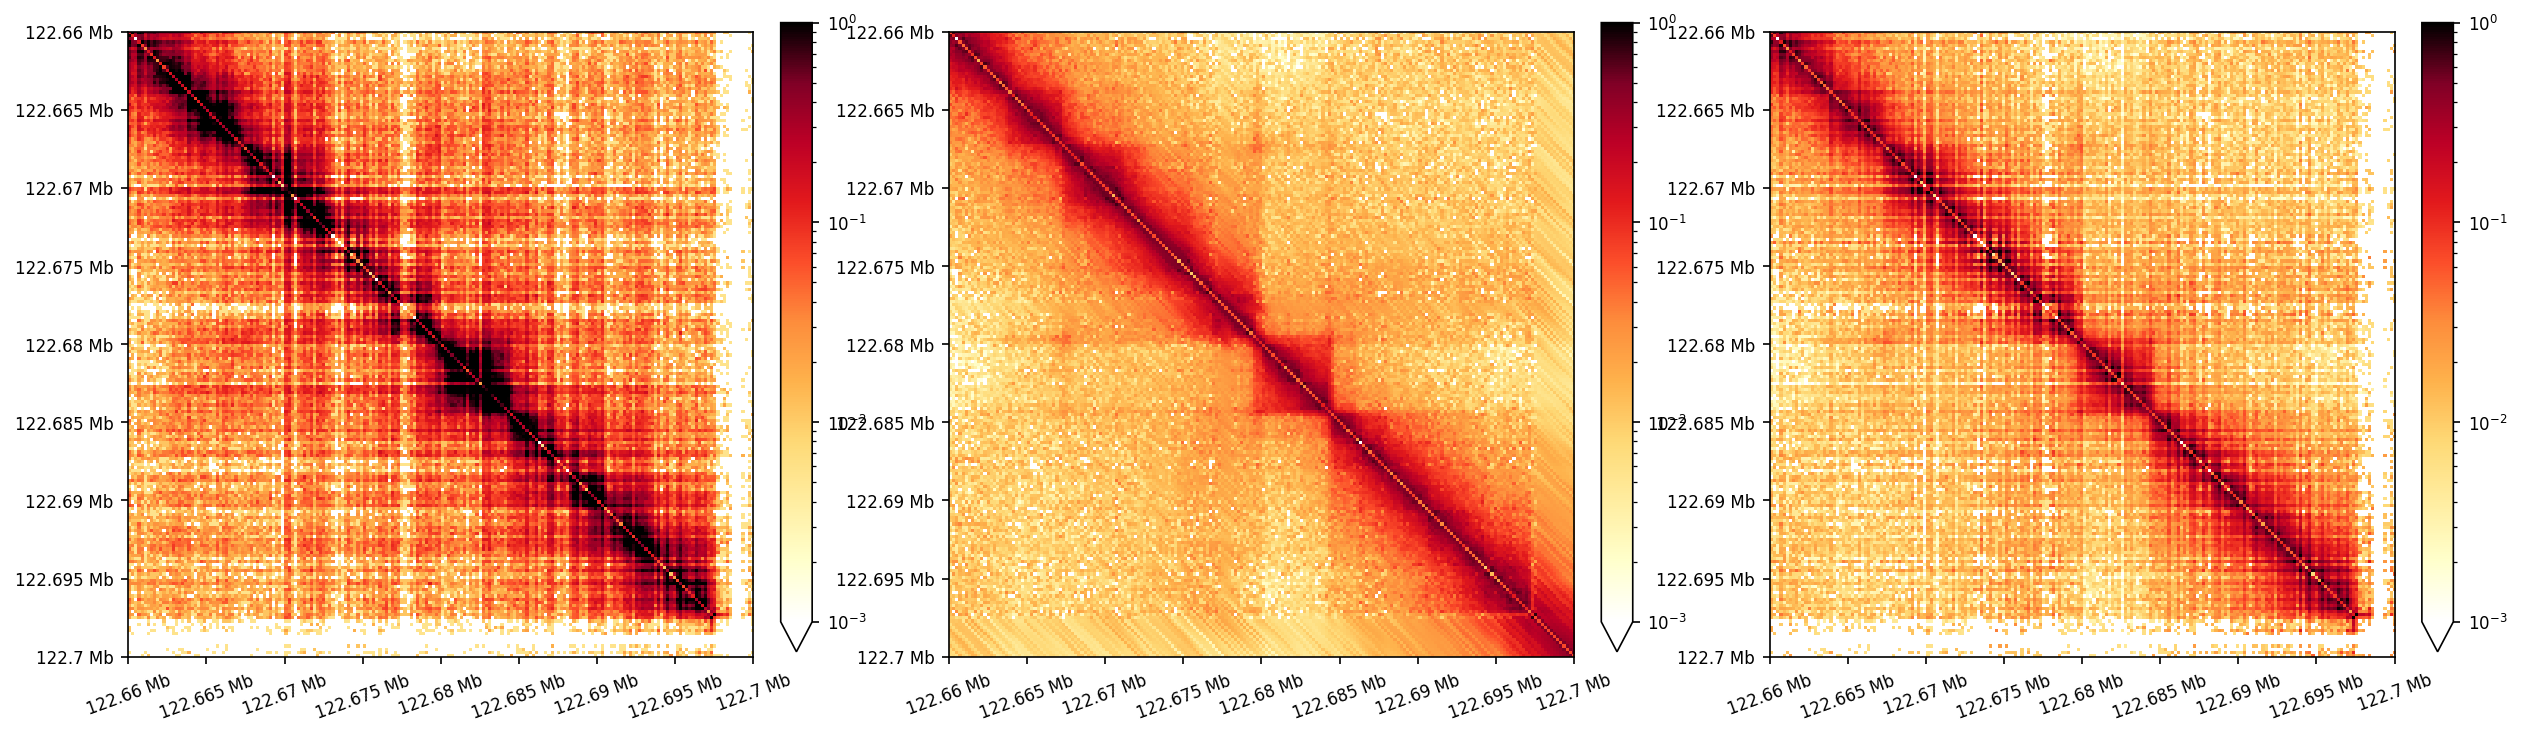

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(20, 8))
plot_contact_map(contact_maps['raw'] / np.nanmean(np.diagonal(contact_maps['raw'], 1)), region, ax=ax[0], vmin=1e-3)
plot_contact_map(contact_maps['neighbor'], region, ax=ax[1], vmin=1e-3, vmax=1)
plot_contact_map(contact_maps['neighbor, direct'], region, ax=ax[2], vmin=1e-3, vmax=1)

ax[0].set_xlim(122_660_000, 122_700_000)
ax[1].set_xlim(122_660_000, 122_700_000)
ax[2].set_xlim(122_660_000, 122_700_000)
ax[0].set_ylim(122_700_000, 122_660_000)
ax[1].set_ylim(122_700_000, 122_660_000)
ax[2].set_ylim(122_700_000, 122_660_000)
plt.show()